# Observatorium


Svrha je ove *Jupyter* bilježnice malo pregledati (opservirati) skup podataka na osnovu kojeg treba izgraditi model kao rješenje zadatka za natjecanje *Mozgalo* 2019. godine.


## Sadržaj


1.  [Učitavanje podataka](#ucitavanje-podataka)
2.  [Jednostavni pregled podataka](#jednostavni-pregled-podataka)
    1.  [Inspekcija sumnjivih dijelova](#inspekcija-sumnjivih-dijelova)
3.  [Vremenski nizovi](#vremenski-nizovi)


Pripremimo prvo okruženje


In [1]:
##  PRIPREMA PYTHON OKRUZENJA

# IPython
from IPython import *
from IPython.display import *

# Standardna Python biblioteka
import copy
import math
import os
import six
import sys
import time

# SciPy paketi
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym
from mpl_toolkits.mplot3d.axes3d import Axes3D # 3-dimenzionalna grafika

# Postavi radni direktorij na poddirektorij `data'.
os.chdir('./data')

# Postavi prikaz grafova unutar biljeznice.
%matplotlib inline

# Postavi stil grafova na `ggplot'.
plt.style.use('ggplot')

# Inicijaliziraj ispis simbolickog racuna.
sym.init_printing()


## Učitavanje podataka <a name="ucitavanje-podataka"></a>


Podatke ćemo iz datoteke *training_dataset_enc.csv* učitati kao `pandas.DataFrame` pozivom funkcije `pandas.read_pickle` odnosno `pandas.read_csv`. Pokretanjem sljedećih programskih linija može se primijetiti da učitavanje podataka iz *CSV* datoteke traje jako dugo zato što redaka u tablici ima više od $ 5 $ milijuna, stoga ćemo prvo pokušati otvoriti *pickle*, a, ako datoteka koju tražimo ne postoji, tek ćemo onda otvarati *CSV* i odmah ćemo učitanu tablicu spremiti kao *pickle* datoteku za kasnije brže učitavanje. Izmjerit ćemo i vrijeme potrebno za učitavanje podataka jer se iz izmjerenih vremena jasno vidi vremenska optimizacija učitavanja podataka.


In [2]:
##  UCITAVANJE SKUPA PODATAKA
##
##  S obzirom na to da je skup podataka vrlo velik (5 193 124 redaka), mjerit
##  cemo i vrijeme potrebno za njegovo ucitavanje.  Podatci bi se, medutim, iz
##  CSV datoteke puno brze ucitali da se datumi ne parsiraju, nego da ostanu
##  stringovi, ali vjerojatno ce nam datumi ionako biti potrebni u datumskom
##  obliku pa ih je bolje odmah takve i ucitati.  Stoga, jednom kada se CSV
##  ucita, sprema se pickle cijelog skupa podataka tako da svaki sljedeci put
##  ucitavanje bude puno brze (ako datoteka s pickle-om postoji, automatski se
##  skup podataka cita iz nje; CSV se cita tek ako datoteka s pickle-om ne
##  postoji).

# Pocni mjeriti vrijeme.
t0 = time.time()


# Ucitaj skup podataka.  Prvo se pokusava ucitati pickle iz datoteke
# `training_dataset_enc.pkl', a, ako ta datoteka ne postoji, onda se ucitava
# tablica u CSV obliku iz `training_dataset_enc.csv' i odmah se sprema pickle u
# datoteku `training_dataset_enc.pkl' za brze ucitavanje ubuduce.
df = None
try:
    df = pd.read_pickle('training_dataset_enc.pkl')
except FileNotFoundError:
    df = pd.read_csv(
        'training_dataset_enc.csv',
        index_col = 0,
        parse_dates = [
            'DATUM_IZVJESTAVANJA',
            'DATUM_OTVARANJA',
            'PLANIRANI_DATUM_ZATVARANJA',
            'DATUM_ZATVARANJA'
        ],
        infer_datetime_format = True,
        true_values = ['Y'],
        false_values = ['N']
    )
    df.drop(columns = 'Unnamed: 0.1', inplace = True)
    df.reset_index(drop = True, inplace = True)
    df.KLIJENT_ID = df.KLIJENT_ID.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.KLIJENT_ID[pd.notnull(df.KLIJENT_ID)].unique()
            ),
            ordered = False
        )
    )
    df.OZNAKA_PARTIJE = df.OZNAKA_PARTIJE.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.OZNAKA_PARTIJE[pd.notnull(df.OZNAKA_PARTIJE)].unique()
            ),
            ordered = False
        )
    )
    df.VALUTA = df.VALUTA.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(df.VALUTA[pd.notnull(df.VALUTA)].unique()),
            ordered = False
        )
    )
    df.VRSTA_KLIJENTA = df.VRSTA_KLIJENTA.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.VRSTA_KLIJENTA[pd.notnull(df.VRSTA_KLIJENTA)].unique()
            ),
            ordered = False
        )
    )
    df.PROIZVOD = df.PROIZVOD.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(df.PROIZVOD[pd.notnull(df.PROIZVOD)].unique()),
            ordered = False
        )
    )
    df.VRSTA_PROIZVODA = df.VRSTA_PROIZVODA.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.VRSTA_PROIZVODA[pd.notnull(df.VRSTA_PROIZVODA)].unique()
            ),
            ordered = False
        )
    )
    df.TIP_KAMATE = df.TIP_KAMATE.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.TIP_KAMATE[pd.notnull(df.TIP_KAMATE)].unique()
            ),
            ordered = False
        )
    )
    df.sort_values(
        [
            'DATUM_IZVJESTAVANJA',
            'DATUM_OTVARANJA',
            'PLANIRANI_DATUM_ZATVARANJA',
            'DATUM_ZATVARANJA',
            'PRIJEVREMENI_RASKID'
        ],
        ascending = [True, True, True, True, False],
        inplace = True
    )
    df.reset_index(drop = True, inplace = True)
    df.to_pickle('training_dataset_enc.pkl')

# Zavrsi mjerenje vremena.
t1 = time.time()

# Izracunaj vremenski period od t0 do t1 u sekundama.
d = float(t1 - t0)

# Ispisi vrijeme.
print(
    'Trajanje ucitavanja: {h:d}h {m:02d}m {s:06.3f}s ({S:.3f}s)'.format(
        h = int(math.floor(d / 3600)),
        m = int(math.floor((d - 3600 * int(math.floor(d / 3600))) / 60)),
        s = d - 60 * int(math.floor(d / 60)),
        S = d
    )
)

# Oslobodi memoriju.
del d
del t0
del t1


/usr/lib/python3/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Trajanje ucitavanja: 0h 04m 47.432s (287.432s)


## Jednostavni pregled podataka <a name="jednostavni-pregled-podataka"></a>


Sada kada su podatci učitani, promotrimo malo kakvi su. Pregledat ćemo u kakvom su formatu podatci spremljeni, kako izgledaju neki od prvih i zadnjih redaka u tablici, a zatim ćemo nad svim stupcima izvršiti minimalnu deskriptivnu statistiku.


In [3]:
# Opis `feature'-a
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5193124 entries, 0 to 5193123
Data columns (total 17 columns):
DATUM_IZVJESTAVANJA               datetime64[ns]
KLIJENT_ID                        category
OZNAKA_PARTIJE                    category
DATUM_OTVARANJA                   datetime64[ns]
PLANIRANI_DATUM_ZATVARANJA        datetime64[ns]
DATUM_ZATVARANJA                  datetime64[ns]
UGOVORENI_IZNOS                   float64
STANJE_NA_KRAJU_PRETH_KVARTALA    float64
STANJE_NA_KRAJU_KVARTALA          float64
VALUTA                            category
VRSTA_KLIJENTA                    category
PROIZVOD                          category
VRSTA_PROIZVODA                   category
VISINA_KAMATE                     float64
TIP_KAMATE                        category
STAROST                           int64
PRIJEVREMENI_RASKID               bool
dtypes: bool(1), category(7), datetime64[ns](4), float64(4), int64(1)
memory usage: 462.3 MB


In [4]:
# Prvih nekoliko redaka
df.head()


,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
0,2011-03-31,1287,256528,1995-10-19,2011-01-11,NaT,0.0,32761.66,32941.42,2,1410,TM0109,L,2.3,C,900,False
1,2011-03-31,1588,256644,1996-03-06,2011-01-23,NaT,0.0,95994.03,96616.95,2,1410,TM0109,L,2.7,C,61,False
2,2011-03-31,1145,293918,1996-07-03,2011-07-31,NaT,71552.0,4957.10,2730.69,4,1610,FL1306,A,4.0,C,55,False
3,2011-03-31,3349,257283,1996-07-16,2011-07-28,NaT,0.0,65791.77,65770.70,2,1410,TM0109,L,3.3,C,86,False
4,2011-03-31,3363,257287,1996-07-17,2011-01-10,NaT,0.0,88678.13,89342.01,2,1550,TM0109,L,3.1,C,69,False


In [5]:
# Zadnjih nekoliko redaka
df.tail()


,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
5193119,2018-12-31,1837639,113622154,2018-12-31,NaT,NaT,65000.00,NaN,65000.00,1,1410,FL0801,A,6.43,B,35,False
5193120,2018-12-31,439084,113617381,2018-12-31,NaT,NaT,523500.00,NaN,523500.00,1,1410,FL1301,A,3.50,B,43,False
5193121,2018-12-31,424518,113612571,2018-12-31,NaT,NaT,60000.00,NaN,60000.00,1,1550,TM0109,L,0.20,A,51,False
5193122,2018-12-31,599106,113615201,2018-12-31,NaT,NaT,27199.73,NaN,27199.73,2,1610,TM0109,L,0.02,A,46,False
5193123,2018-12-31,628584,113620442,2018-12-31,NaT,NaT,61000.00,NaN,60024.63,1,1410,FL0801,A,6.80,A,41,False


Definirat cemo i neke funkcije koje ce nam olaksati jednostavnu analizu stupaca.


In [6]:
##  DEFINICIJE NEKIH FUNKCIJA ZA ANALIZU PODATAKA

def analiziraj_num_stupac (col):
    """
    Saznaj neke podatke o stupcu s numerickim vrijednostima.

    Argument col trebao bi biti dobiven ekstrakcijom stupca iz neke tablice
    (objekt tipa pandas.DataFrame) i trebao bi biti numerickog tipa.  Ako ti
    zahtjevi nisu ispunjeni, ponasanje funkcije moze biti neocekivano.

    Povratni objekt je rjecnik (objekt tipa dict) s kljucevima i vrijednostima:
        --  'min'   --  najmanja vrijednost u stupcu,
        --  'max'   --  najveca vrijednost u stupcu,
        --  'range' --  raspon vrijednosti u stupcu (max - min),
        --  'nulls' --  broj nedefiniranih vrijednosti u stupcu,
        --  'uniques'   --  broj jedinstvenih definiranih vrijednosti u stupcu.

    Ostatak deskriptivne statistike ne racuna se jer se takvi podatci (pa cak i
    neki od ovdje izracunatih) mogu dehvatiti pozivom metode
    pandas.DataFrame.describe.

    """

    nonvalids = pd.isnull(col)
    extrmin = col.min()
    extrmax = col.max()

    return {
        'min' : extrmin,
        'max' : extrmax,
        'range' : extrmax - extrmin,
        'nulls' : int(nonvalids.sum()),
        'uniques' : int(col[np.logical_not(nonvalids)].unique().size)
    }

def analiziraj_bool_stupac (col):
    """
    Saznaj neke podatke o stupcu s vrijednostima istina/laz.

    Argument col trebao bi biti dobiven ekstrakcijom stupca iz neke tablice
    (objekt tipa pandas.DataFrame) i trebao bi biti vrijednosti istina/laz.  Ako
    ti zahtjevi nisu ispunjeni, ponasanje funkcije moze biti neocekivano.  Ipak,
    ponekad je korisno i za, na primjer, numericke stupce saznati koliko imaju
    vrijednosti jednakih 0, a koliko razlicitih 0: poziv ove funkcije nad
    numerickim stupcem vraca upravo takve podatke.  U biti, sve se definirane
    vrijednosti u stupcu prvo pokusaju interpretirati kao vrijednosti istina/laz
    i onda se takav stupac analizira.  Dakle, ponasanje i povratna vrijednost
    funkcije ovise o nacinu konverzije podataka.

    Povratni objekt je rjecnik (objekt tipa dict) s kljucevima i vrijednostima:
        --  'nulls' --  broj nedefiniranih vrijednosti u stupcu,
        --  'trues' --  broj istinitih vrijednosti u stupcu,
        --  'falses'    --  broj laznih vrijednosti u stupcu.

    """

    nonvalids = pd.isnull(col)
    bools = col[np.logical_not(nonvalids)].astype(bool)
    trues = int(bools.sum())
    falses = int(bools.size - trues)

    return {
        'nulls' : int(nonvalids.sum()),
        'trues' : trues,
        'falses' : falses
    }

def analiziraj_str_stupac (col):
    """
    Saznaj neke podatke o stupcu s kategorickim vrijednostima.

    Argument col trebao bi biti dobiven ekstrakcijom stupca iz neke tablice
    (objekt tipa pandas.DataFrame) i trebao bi sadrzavati kategoricke
    vrijednosti (najcesce u obliku stringova, ali moze biti i bilo kojeg drugog
    tipa).

    Povratni objekt je rjecnik (objekt tipa dict) s kljucevima i vrijednostima:
        --  'nulls' --  broj nedefiniranih vrijednosti u stupcu,
        --  'uniques'   --  broj jedinstvenih definiranih vrijednosti u stupcu.

    """

    nonvalids = pd.isnull(col)

    return {
        'nulls' : int(nonvalids.sum()),
        'uniques' : int(col[np.logical_not(nonvalids)].unique().size)
    }


Slijede kratke analize stupaca. Iz poziva funkcija je evidentno kojem stupcu odgovara koji ispis (svi su stupci, osim prvog jer njegovo značenje nije jasno<sup>[1](#fnote-1), [2](#fnote-2)</sup>, analizirani, a čak su analizirane i razlike između stupaca *DATUM_OTVARANJA*, *PLANIRANI_DATUM_ZATVARANJA* i *DATUM_ZATVARANJA*, stupaca *STANJE_NA_KRAJU_KVARTALA* i *STANJE_NA_KRAJU_PRETH_KVARTALA* i stupaca *UGOVORENI_IZNOS* i *STANJE_NA_KRAJU_KVARTALA*, ali stupci nisu analizirani redom kojim se pojavljuju u tablici).


In [7]:
analiziraj_str_stupac(df.KLIJENT_ID)


{'nulls': 0, 'uniques': 256858}

In [8]:
analiziraj_str_stupac(df.OZNAKA_PARTIJE)


{'nulls': 0, 'uniques': 579332}

In [9]:
analiziraj_str_stupac(df.VRSTA_KLIJENTA)


{'nulls': 0, 'uniques': 13}

In [10]:
analiziraj_str_stupac(df.VRSTA_PROIZVODA)


{'nulls': 0, 'uniques': 2}

In [11]:
analiziraj_str_stupac(df.PROIZVOD)


{'nulls': 0, 'uniques': 32}

In [12]:
analiziraj_str_stupac(df.VALUTA)


{'nulls': 0, 'uniques': 5}

In [13]:
analiziraj_str_stupac(df.TIP_KAMATE)


{'nulls': 0, 'uniques': 4}

In [14]:
analiziraj_num_stupac(df.STAROST)


{'max': 908, 'min': -7994, 'nulls': 0, 'range': 8902, 'uniques': 130}

In [15]:
analiziraj_num_stupac(df.DATUM_IZVJESTAVANJA)


{'max': Timestamp('2018-12-31 00:00:00'),
 'min': Timestamp('2011-03-31 00:00:00'),
 'nulls': 0,
 'range': Timedelta('2832 days 00:00:00'),
 'uniques': 32}

In [16]:
analiziraj_num_stupac(df.DATUM_OTVARANJA)


{'max': Timestamp('2018-12-31 00:00:00'),
 'min': Timestamp('1995-10-19 00:00:00'),
 'nulls': 0,
 'range': Timedelta('8474 days 00:00:00'),
 'uniques': 6207}

In [17]:
analiziraj_num_stupac(df.PLANIRANI_DATUM_ZATVARANJA)


{'max': Timestamp('2048-09-30 00:00:00'),
 'min': Timestamp('1999-05-31 00:00:00'),
 'nulls': 421129,
 'range': Timedelta('18020 days 00:00:00'),
 'uniques': 4769}

In [18]:
analiziraj_num_stupac(df.DATUM_ZATVARANJA)


{'max': Timestamp('2018-12-31 00:00:00'),
 'min': Timestamp('2005-01-21 00:00:00'),
 'nulls': 3978638,
 'range': Timedelta('5092 days 00:00:00'),
 'uniques': 3077}

In [19]:
analiziraj_num_stupac(df.PLANIRANI_DATUM_ZATVARANJA - df.DATUM_OTVARANJA)


{'max': Timedelta('14635 days 00:00:00'),
 'min': Timedelta('-2308 days +00:00:00'),
 'nulls': 421129,
 'range': Timedelta('16943 days 00:00:00'),
 'uniques': 7014}

In [20]:
analiziraj_num_stupac(df.DATUM_ZATVARANJA - df.PLANIRANI_DATUM_ZATVARANJA)


{'max': Timedelta('6791 days 00:00:00'),
 'min': Timedelta('-11620 days +00:00:00'),
 'nulls': 4011681,
 'range': Timedelta('18411 days 00:00:00'),
 'uniques': 7600}

In [21]:
analiziraj_num_stupac(df.DATUM_ZATVARANJA - df.DATUM_OTVARANJA)


{'max': Timedelta('7762 days 00:00:00'),
 'min': Timedelta('-324 days +00:00:00'),
 'nulls': 3978638,
 'range': Timedelta('8086 days 00:00:00'),
 'uniques': 5809}

In [22]:
analiziraj_bool_stupac(df.PRIJEVREMENI_RASKID)


{'falses': 4876819, 'nulls': 0, 'trues': 316305}

In [23]:
analiziraj_num_stupac(df.UGOVORENI_IZNOS)


{'max': 605504800.0,
 'min': 0.0,
 'nulls': 0,
 'range': 605504800.0,
 'uniques': 675756}

In [24]:
analiziraj_num_stupac(df.VISINA_KAMATE)


{'max': 80.8, 'min': -0.004, 'nulls': 51702, 'range': 80.804, 'uniques': 1796}

In [25]:
analiziraj_num_stupac(df.STANJE_NA_KRAJU_PRETH_KVARTALA)


{'max': 610566240.0,
 'min': -59.81,
 'nulls': 421068,
 'range': 610566299.81,
 'uniques': 2776041}

In [26]:
analiziraj_num_stupac(df.STANJE_NA_KRAJU_KVARTALA)


{'max': 610566240.0,
 'min': -59.81,
 'nulls': 0,
 'range': 610566299.81,
 'uniques': 2746314}

In [27]:
analiziraj_num_stupac(
    df.STANJE_NA_KRAJU_KVARTALA - df.STANJE_NA_KRAJU_PRETH_KVARTALA
)


{'max': 77423644.13,
 'min': -381313350.0,
 'nulls': 421068,
 'range': 458736994.13,
 'uniques': 2183943}

In [28]:
analiziraj_num_stupac(df.STANJE_NA_KRAJU_KVARTALA - df.UGOVORENI_IZNOS)

{'max': 29531228.0,
 'min': -569612740.44,
 'nulls': 0,
 'range': 599143968.44,
 'uniques': 3108583}

<sup><a name="fnote-1"></a>1</sup> Na prijedlog Domagoja Ravlića zaključili smo da je skup podataka dobiven odabirom i ekstrakcijom nekih redaka u nekom većem skupu podataka, a da vrijednosti u prvom stupcu označavaju redne brojeve redaka u tom većem skupu podataka. &larr; **POTVRDIO NARUČITELJ ZADATKA**

<sup><a name="fnote-2"></a>2</sup> Stupac *Unnamed: 0.1* je izbačen iz tablice.


### Inspekcija sumnjivih dijelova <a name="inspekcija-sumnjivih-dijelova"></a>


U analizi stupaca možemo primijetiti, na primjer, da postoji i negativna starost<sup>[3](#fnote-3)</sup> (minimum u stupcu *STAROST* iznosi $ {- 7994} $ &mdash; prije nešto više od $ 7 $ tisuća godina je smještena radnja *Knjige postanka* u *Bibliji*, dakle, do osnutka odnosno rođenja ovog klijenta morali bismo pričekati otprilike onoliko koliko je prošlo od rođenja Adama i Eve ili, malo znanstvenije, od novog kamenog doba ili bakrenog doba u nekim dijelovima svijeta).

Provjerimo sada sve negativne starosti.


In [29]:
df.loc[df.STAROST < 0].head()


,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
1870,2011-03-31,317491,428392,2001-10-04,2011-03-16,NaT,46194.39,31031.37,29566.47,3,1410,TM0109,L,2.1,C,-7994,False
17927,2011-03-31,81683,917728,2005-05-17,2015-11-18,NaT,1974389.50,1215790.25,1110042.17,4,1210,FI0500,A,0.0,B,-7994,False
60539,2011-03-31,618326,642999,2007-10-05,2011-10-08,NaT,58234.44,58234.44,58234.44,1,1410,TM0109,L,4.6,C,-7994,False
105099,2011-03-31,991796,4786159,2009-12-02,2012-12-31,NaT,6700951.27,1870059.25,1869460.14,2,1110,FP0100,A,0.0,B,-7994,False
105103,2011-03-31,991796,4786161,2009-12-02,2014-12-31,NaT,25547376.68,16748886.36,16743520.49,2,1110,FP0100,A,0.0,B,-7994,False


In [30]:
df.loc[df.STAROST < 0].shape[0]


Primijećujemo da su zapravo negativne starosti jako polarizirane: ili su u intervalu $ \left[ {- 4} \mathinner{\ldotp \ldotp} {- 1} \right] $ ili su u intervalu $ \left[ {- 7986} \mathinner{\ldotp \ldotp} {- 7994} \right] $. Stoga ćemo te dvije skupine zasebno analizirati.


Prvo analizirajmo gornju skupinu (starosti iz intervala $ \left[ {- 4} \mathinner{\ldotp \ldotp} {- 1} \right] $).


In [31]:
df.loc[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)].head()


,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
364443,2011-06-30,1292900,6029553,2011-05-13,NaT,2011-05-27,75000.0,NaN,0.0,1,1320,TM0109,L,0.2,A,-4,False
367413,2011-06-30,1292900,6085713,2011-05-27,NaT,2011-06-06,75000.0,NaN,0.0,1,1320,TM0109,L,0.2,A,-4,False
369263,2011-06-30,1292900,6347768,2011-06-06,NaT,2011-06-28,75000.0,NaN,0.0,1,1320,TM0109,L,0.2,A,-4,False
373845,2011-06-30,1292900,6371080,2011-06-28,NaT,NaT,75000.0,NaN,75000.0,1,1320,TM0109,L,0.2,A,-4,False
560777,2011-09-30,1292900,6029553,2011-05-13,2011-05-27,2011-05-27,75000.0,0.0,0.0,1,1320,TM0109,L,0.2,A,-4,False


In [32]:
df.loc[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)].shape[0]


In [33]:
df.STAROST[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)].describe()


count    23.000000
mean     -2.826087
std       1.114050
min      -4.000000
25%      -4.000000
50%      -3.000000
75%      -2.000000
max      -1.000000
Name: STAROST, dtype: float64

In [34]:
analiziraj_num_stupac(
    df.STAROST[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)]
)


{'max': -1, 'min': -4, 'nulls': 0, 'range': 3, 'uniques': 4}

(array([8., 0., 0., 7., 0., 0., 4., 0., 0., 4.]),
 array([-4. , -3.7, -3.4, -3.1, -2.8, -2.5, -2.2, -1.9, -1.6, -1.3, -1. ]),
 <a list of 10 Patch objects>)

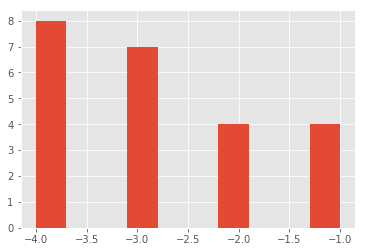

In [35]:
plt.hist(df.STAROST[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)])


Analizirajmo sada i donju skupinu (starosti iz intervala $ \left[ {- 7986} \mathinner{\ldotp \ldotp} {- 7994} \right] $).


In [36]:
df.loc[df.STAROST < -1000].head()


,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
1870,2011-03-31,317491,428392,2001-10-04,2011-03-16,NaT,46194.39,31031.37,29566.47,3,1410,TM0109,L,2.1,C,-7994,False
17927,2011-03-31,81683,917728,2005-05-17,2015-11-18,NaT,1974389.50,1215790.25,1110042.17,4,1210,FI0500,A,0.0,B,-7994,False
60539,2011-03-31,618326,642999,2007-10-05,2011-10-08,NaT,58234.44,58234.44,58234.44,1,1410,TM0109,L,4.6,C,-7994,False
105099,2011-03-31,991796,4786159,2009-12-02,2012-12-31,NaT,6700951.27,1870059.25,1869460.14,2,1110,FP0100,A,0.0,B,-7994,False
105103,2011-03-31,991796,4786161,2009-12-02,2014-12-31,NaT,25547376.68,16748886.36,16743520.49,2,1110,FP0100,A,0.0,B,-7994,False


In [37]:
df.loc[df.STAROST < -1000].shape[0]


In [38]:
df.STAROST[df.STAROST < -1000].describe()


count    3344.000000
mean    -7987.241926
std         1.278142
min     -7994.000000
25%     -7988.000000
50%     -7987.000000
75%     -7987.000000
max     -7986.000000
Name: STAROST, dtype: float64

In [39]:
analiziraj_num_stupac(df.STAROST[df.STAROST < -1000])


{'max': -7986, 'min': -7994, 'nulls': 0, 'range': 8, 'uniques': 9}

(array([  17.,   45.,   38.,   28.,    0.,   18.,   14.,  812., 1596.,
         776.]),
 array([-7994. , -7993.2, -7992.4, -7991.6, -7990.8, -7990. , -7989.2,
        -7988.4, -7987.6, -7986.8, -7986. ]),
 <a list of 10 Patch objects>)

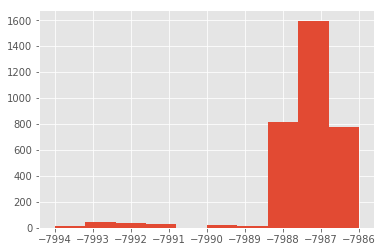

In [40]:
plt.hist(df.STAROST[df.STAROST < -1000])


Neobično je, također, i što postoji starost veća (ne nužno strogo) od $ 900 $ godina<sup>[3](#fnote-3)</sup>. Zapravo, pozitivne starosti su također polarizirane u intervale $ \left[ 1 \mathinner{\ldotp \ldotp} 107 \right] $ i $ \left[ 900 \mathinner{\ldotp \ldotp} 908 \right] $. Naravno da je moguće da je neko poduzeće staro $ 900 $-tinjak godina, ali prvi moderni bankari bili su križari &mdash; to bi značilo da su najstariji suvremeni klijenti *RBA* bankarske usluge mogli tražiti još od prvih bankara na svijetu. Za razliku od negativne starosti, ovaj fenomen nije nemoguć, ali vrlo je malo vjerojatan.

Promotrimo, dakle, te dijelove tablice.


In [41]:
df.loc[df.STAROST >= 500].head()


,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
0,2011-03-31,1287,256528,1995-10-19,2011-01-11,NaT,0.00,32761.66,32941.42,2,1410,TM0109,L,2.3,C,900,False
15,2011-03-31,3089,261055,1997-11-24,2011-12-05,NaT,0.00,21421.36,21414.50,2,1410,TM0109,L,3.0,C,900,False
67,2011-03-31,1470,269186,1999-12-28,2011-06-02,NaT,14611.16,10730.63,10106.18,3,1410,TM0109,L,2.1,C,900,False
107,2011-03-31,11327,271575,2000-06-27,2011-03-26,NaT,13140.28,12632.41,12697.03,2,1410,TM0109,L,2.2,C,900,False
259,2011-03-31,3089,274049,2000-12-15,2011-12-24,NaT,33222.16,32300.16,32289.81,2,1410,TM0109,L,3.0,C,900,False


In [42]:
df.loc[df.STAROST >= 500].shape[0]


In [43]:
df.STAROST[df.STAROST >= 500].describe()


count    467.000000
mean     903.304069
std        2.234543
min      900.000000
25%      901.000000
50%      903.000000
75%      905.000000
max      908.000000
Name: STAROST, dtype: float64

In [44]:
analiziraj_num_stupac(df.STAROST[df.STAROST >= 500])


{'max': 908, 'min': 900, 'nulls': 0, 'range': 8, 'uniques': 9}

(array([55., 76., 62., 47.,  0., 69., 77., 35., 37.,  9.]),
 array([900. , 900.8, 901.6, 902.4, 903.2, 904. , 904.8, 905.6, 906.4,
        907.2, 908. ]),
 <a list of 10 Patch objects>)

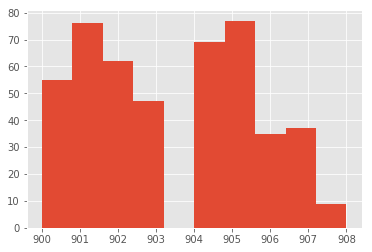

In [45]:
plt.hist(df.STAROST[df.STAROST >= 500])


<sup><a name="fnote-3"></a>3</sup> Za klijente čija je starost negativna ili nevjerojatno velika ne zna se datum osnutka odnosno rođenja. &larr; **OBJASNIO NARUČITELJ ZADATKA**


***TO DO:*** Pogledati i ostala sumnjiva mjesta (gdje je planirani datum zatvaranja ili datum zatvaranja prije datuma otvaranja).


## Vremenski nizovi <a name="vremenski-nizovi"></a>


Pokušat ćemo iz danih podataka konstruirati vremenske nizove za klijente. Da bismo to napravili, grupirajmo prvo podatke s obzirom na klijente odnosno na klijente i partije.


In [46]:
k_df = df.groupby('KLIJENT_ID')


In [47]:
kp_df = df.groupby(['KLIJENT_ID', 'OZNAKA_PARTIJE'])


Sortirajmo vrijednosti $ \text{KLIJENT_ID} $ u niz `k` tako da za svaki $ \mathtt{i} \in \left( 0 \mathinner{\ldotp \ldotp} \mathtt{len(k)} - 2 \right) $ tablica `k_df.get_group(k[i])` ima više (ne nužno strogo) redaka od tablice `k_df.get_group(k[i + 1])`. Analogno učinimo s uređenim parovima $ \left( \text{KLIJENT_ID} , \text{OZNAKA_PARTIJE} \right) $ u nizu `kp`.


In [48]:
k = np.array(
    k_df.size().sort_values(ascending = False).index,
    dtype = int,
    order = 'C'
)


In [49]:
kp = np.array(
    [list(kp_x) for kp_x in kp_df.size().sort_values(ascending = False).index],
    dtype = int,
    order = 'C'
)


Konačno, definirajmo klase `VremenskiNiz` i `Klijent` čije će instance *reprezentirati* vremenske nizove konkretnih partija klijenta i vremenske nizove svih partija klijenta reprezentativno (instance tih klasa ne će zapravo reprezentirati vremenske nizove, nego će samo sadržavati atribute s ekstrahiranim podatcima iz originalne tablice sortiranim s obzirom na vrijeme).


In [50]:
##  DEFINICIJE NEKIH KLASA ZA EKSTRAKCIJU VREMENSKIH NIZOVA

class VremenskiNiz (object):
    """
    Klasa za reprezentaciju vremenskog niza zbivanja jedne partije.

    """

    @classmethod
    def prviDatum (cls, stupac):
        """
        Dohvati prvi definirani datum u stupcu.

        Ako ne postoji, povratna vrijednost je pandas.NaT.

        """

        i = stupac.first_valid_index()

        if i is None:
            return pd.NaT

        return stupac.loc[i]

    @classmethod
    def zadnjiDatum (cls, stupac):
        """
        Dohvati prvi definirani datum u stupcu.

        Ako ne postoji, povratna vrijednost je pandas.NaT.

        """

        i = stupac.last_valid_index()

        if i is None:
            return pd.NaT

        return stupac.loc[i]

    def __init__ (self, KLIJENT_ID, OZNAKA_PARTIJE, copy = False):
        """
        Inicijaliziraj vremenski niz partija klijenta.

        Postavljaju se atributi KLIJENT_ID, OZNAKA_PARTIJE, df
        (kp_df.get_group(self.KLIJENT_ID, self.OZNAKA_PARTIJE)) i cmpkey
        (lista nekih vrijednosti koja se leksikografski usporeduje s
        other.cmpkey kod poziva operatora uredaja).

        Tablica se pokusava iscitati iz indeksa redaka spremljenih kao
        numpy.ndarray u datoteci `klijent/{KLIJENT_ID}/{OZNAKA_PARTIJE}.npy';
        tek ako ta datoteka ne postoji, tablica se dobije pozivom metode
        kp_df.get_group i sortiranjem (a indeksi redaka u tablici df spremaju se
        u spomenutu datoteku).

        """

        self.KLIJENT_ID = int(KLIJENT_ID)
        self.OZNAKA_PARTIJE = int(OZNAKA_PARTIJE)
        self.df = None
        try:
            self.df = pd.read_pickle(
                'klijent/{0:d}/{1:d}.pkl'.format(
                    self.KLIJENT_ID,
                    self.OZNAKA_PARTIJE
                )
            ) if copy else df.loc[
                np.load(
                    'klijent/{0:d}/{1:d}.npy'.format(
                        self.KLIJENT_ID,
                        self.OZNAKA_PARTIJE
                    )
                )
            ]
        except FileNotFoundError:
            self.df = kp_df.get_group(
                (self.KLIJENT_ID, self.OZNAKA_PARTIJE)
            ).sort_values(
                [
                    'DATUM_IZVJESTAVANJA',
                    'DATUM_OTVARANJA',
                    'PLANIRANI_DATUM_ZATVARANJA',
                    'DATUM_ZATVARANJA',
                    'PRIJEVREMENI_RASKID'
                ],
                ascending = [True, True, True, True, False]
            )
            os.makedirs(
                'klijent/{0:d}'.format(self.KLIJENT_ID),
                exist_ok = True
            )
            np.save(
                'klijent/{0:d}/{1:d}.npy'.format(
                    self.KLIJENT_ID,
                    self.OZNAKA_PARTIJE
                ),
                np.array(self.df.index, dtype = int, order = 'C')
            )
            self.df.to_pickle(
                'klijent/{0:d}/{1:d}.npy'.format(
                    self.KLIJENT_ID,
                    self.OZNAKA_PARTIJE
                )
            )
            if copy:
                self.df = self.df.copy()

        nbreak = np.flipud(
            np.logical_not(
                np.flipud(self.df.PRIJEVREMENI_RASKID.cumsum()).astype(bool)
            )
        )

        self.cmpkey = np.array(
            [
                [
                    VremenskiNiz.prviDatum(
                        self.df.DATUM_IZVJESTAVANJA.iloc[i:]
                    ),
                    VremenskiNiz.prviDatum(self.df.DATUM_OTVARANJA.iloc[i:]),
                    VremenskiNiz.zadnjiDatum(
                        self.df.PLANIRANI_DATUM_ZATVARANJA.iloc[i:]
                    ),
                    VremenskiNiz.zadnjiDatum(self.df.DATUM_ZATVARANJA.iloc[i:]),
                    nbreak[i]
                ] for i in range(int(self.df.shape[0]))
            ],
            dtype = object,
            order = 'C'
        ).tolist()

    def __copy__ (self):
        """
        Dohvati copy.copy(self).

        """

        return VremenskiNiz(self.KLIJENT_ID, self.OZNAKA_PARTIJE)

    def __deppcopy__ (self, memo = dict()):
        """
        Dohvati copy.deepcopy(self, memo).

        """

        return VremenskiNiz(
            copy.deepcopy(self.KLIJENT_ID, memo),
            copy.deepcopy(self.OZNAKA_PARTIJE, memo),
            True
        )

    def __repr__ (self):
        """
        Dohvati repr(self).

        """

        return '<VremenskiNiz: ({0:d}, {1:d})>'.format(
            self.KLIJENT_ID, self.OZNAKA_PARTIJE
        )

    def __len__ (self):
        """
        Dohvati len(self).

        Vraca se self.df.shape[0].

        """

        return int(self.df.shape[0])

#   def __iter__ (self):
#       """
#       Iteriraj po vremenskom nizu.
#
#       Vracaju se retci u self.df redom od prvog do zadnjeg.
#
#       """
#
#       for i in range(self.df.shape[0]):
#           yield self.df.iloc[i]

    def __getitem__ (self, key):
        """
        Dohvati self[key].

        Vraca se self.df.iloc[key].

        """

        return self.df.iloc[key]

    def __eq__ (self, other):
        """
        Dohvati self == other.

        Usporeduju se atributi KLIJENT_ID, OZNAKA_PARTIJE i svi elementi tablice
        (metodom pandas.DataFrame.equals).

        """

        return (
            self.KLIJENT_ID == other.KLIJENT_ID and
            self.OZNAKA_PARTIJE == other.OZNAKA_PARTIJE and
            self.df.equals(other.df)
        )

    def __ne__ (self, other):
        """
        Dohvati self != other.

        Vraca se negacija od self == other.

        """

        return not self == other

    def __lt__ (self, other):
        """
        Dohvati self < other.

        Uredaj nije totalni (mozda nije ni parcijalni --- ovisi o nedefiniranim
        vrijednostima (NaN)), a usporeduju se samo elementi u stupcima
        DATUM_IZVJESTAVANJA, DATUM_OTVARANJA, PLANIRANI_DATUM_ZATVARANJA,
        DATUM_ZATVARANJA i PRIJEVREMENI_RASKID leksikografskom usporedbom
        self.cmpkey i other.cmpkey.

        """

        return self.cmpkey < other.cmpkey

    def __gt__ (self, other):
        """
        Dohvati self < other.

        Vraca se other < self.

        """

        return other < self

    def __le__ (self, other):
        """
        Dohvati self <= other.

        Uredaj nije totalni (mozda nije ni parcijalni --- ovisi o nedefiniranim
        vrijednostima (NaN)), a usporeduju se samo elementi u stupcima
        DATUM_IZVJESTAVANJA, DATUM_OTVARANJA, PLANIRANI_DATUM_ZATVARANJA,
        DATUM_ZATVARANJA i PRIJEVREMENI_RASKID leksikografskom usporedbom
        self.cmpkey i other.cmpkey.

        Moguce je da ne vrijedi (not (self > other)) == (self <= other), ponovo
        zbog nedefiniranih vrijednosti (NaN).

        """

        return self.cmpkey <= other.cmpkey

    def __ge__ (self, other):
        """
        Dohvati self >= other.

        Vraca se other <= self.

        """

        return other <= self

class Klijent (object):
    def __init__ (self, KLIJENT_ID, copy = False):
        """
        Inicijaliziraj klijenta.

        Postavljaju se atributi KLIJENT_ID i ser (sortirani numpy.ndarray svih
        vremenskih nizova partija danog klijenta).

        Niz partija pokusaca se iscitati iz oznaka partija spremljenih kao
        numpy.ndarray u datoteci `klijent/{KLIJENT_ID}/ser.npy'; tek ako ta
        datoteka ne postoji, niz partija se dobije trazenjem u nizu kp i
        sortiranjem (a oznake partija spremaju se u spomenutu datoteku).

        """

        self.KLIJENT_ID = int(KLIJENT_ID)
        self.ser = None
        try:
            self.ser = np.array(
                [
                    VremenskiNiz(self.KLIJENT_ID, p, copy) for p in np.load(
                        'klijent/{0:d}/ser.npy'.format(self.KLIJENT_ID)
                    )
                ]
            )
        except FileNotFoundError:
            self.ser = np.sort(
                [
                    VremenskiNiz(*kp_x, copy = copy) for kp_x in kp
                        if kp_x[0] == self.KLIJENT_ID
                ]
            )
            os.makedirs(
                'klijent/{0:d}'.format(self.KLIJENT_ID),
                exist_ok = True
            )
            np.save(
                'klijent/{0:d}/ser.npy'.format(self.KLIJENT_ID),
                np.array(
                    [p.OZNAKA_PARTIJE for p in self.ser],
                    dtype = int,
                    order = 'C'
                )
            )

    def __copy__ (self):
        """
        Dohvati copy.copy(self).

        """

        return Klijent(self.KLIJENT_ID)

    def __deepcopy__ (self, memo = dict()):
        """
        Dohvati copy.deepcopy(self, memo).

        """

        return Klijent(copy.deepcopy(self.KLIJENT_ID), True)

    def __repr__ (self):
        """
        Dohvati repr(self).

        """

        return '<Klijent: {0:d}>'.format(self.KLIJENT_ID)

    def __len__ (self):
        """
        Dohvati len(self).

        Vraca se self.ser.size.

        """

        return int(self.ser.size)

    def __iter__ (self):
        """
        Iteriraj po vremenskim nizovima klijenta.

        Vracaju se elementi self.ser redom od prvog do zadnjeg.

        """

        for i in range(self.ser.size):
            yield self.ser[i]

    def __getitem__ (self, key):
        """
        Dohvati self.ser[key].

        """

        return self.ser[key]

    def __eq__ (self, other):
        """
        Dohvati self == other.

        Usporeduju se atribut KLINET_ID i jednakost nizova self.ser i other.ser
        (funkcijom numpy.array_equal).

        """

        return (
            self.KLIJENT_ID == other.KLIJENT_ID and
            np.array_equal(self.ser, other.ser)
        )

    def __ne__ (self, other):
        """
        Dohvati self != other.

        Dohvaca se negacija self == other.

        """

        return not self == other

    def __lt__ (self, other):
        """
        Dohvati self < other.

        Leksikografski se usporeduju self.ser i other.ser.

        Buduci da uredaj na klasi VremenskiNiz nije nuzno totalan, ni ovaj
        uredaj nije nuzno totalan.

        """

        return self.ser.tolist() < other.ser.tolist()

    def __gt__ (self, other):
        """
        Dohvati self > other.

        Vraca se other < self.

        """

        return other < self

    def __le__ (self, other):
        """
        Dohvati self <= other.

        Leksikografski se usporeduju self.ser i other.ser.

        Buduci da uredaj na klasi VremenskiNiz nije nuzno totalan, ni ovaj
        uredaj nije nuzno totalan.

        Moguce je da ne vrijedi (not (self > other)) == (self <= other), ponovo
        zbog netotalnosti uredaja na klasi VremenskiNiz.

        """

        return self.ser.tolist() <= other.ser.tolist()

    def __ge__ (self, other):
        """
        Dohvati self >= other.

        Vraca se other <= self.

        """

        return other <= self


***TO DO:*** Ako je moguće (na učitanom skupu podataka, ne nužno općenito), proširiti uređaj na klasi `VremenskiNiz`, a posredno i na klasi `Klijent`, do totalnog uređaja. Neka eventualno rješenje bude efikasno implementirano.


In [51]:
def isplotaj (partija):
    fig, ax = plt.subplots(nrows = 2, ncols = 2, num = str(partija.OZNAKA_PARTIJE), sharex = True, figsize = (12, 10))

    fig.suptitle('{0:d}, {1:d}'.format(partija.KLIJENT_ID[0], partija.OZNAKA_PARTIJE[0]))

    ax[0, 0].set_title('Ugovoreni iznos')
    ax[0, 0].plot(partija.DATUM_IZVJESTAVANJA, partija.UGOVORENI_IZNOS)

    ax[0, 1].set_title('Visina kamate')
    ax[0, 1].plot(partija.DATUM_IZVJESTAVANJA, partija.VISINA_KAMATE)

    ax[1, 0].set_title('Stanje na kraju kvartala')
    ax[1, 0].plot(partija.DATUM_IZVJESTAVANJA, partija.STANJE_NA_KRAJU_KVARTALA)

    ax[1, 1].set_title('Razlika stanja na kraju ovog i prethodnog kvartala')
    ax[1, 1].plot(partija.DATUM_IZVJESTAVANJA, partija.STANJE_NA_KRAJU_KVARTALA - partija.STANJE_NA_KRAJU_PRETH_KVARTALA)


In [52]:
def grouppie (col, val, df = df):
    if not isinstance(col, str) and hasattr(col, '__iter__'):
        return tuple(grouppie(c, v) for c, v in zip(col, val))

    multi = True
    if isinstance(val, str) or not hasattr(val, '__iter__'):
        multi = False
        val = [val]

    col_df = df.groupby(col)
    val_df = tuple(col_df.get_group(v).groupby(['KLIJENT_ID', 'OZNAKA_PARTIJE']) for v in val)

    kp_val_df = tuple(
        np.array(
            [list(kp_v_x) for kp_v_x in v_df.size().sort_values(ascending = False).index],
            dtype = int,
            order = 'C'
        ) for v_df in val_df
    )

    return (val_df, kp_val_df) if multi else (val_df[0], kp_val_df[0])


In [53]:
def prvi_feat_ing (group_df = kp_df):
    day = np.timedelta64(1, 'D')

    feat_df = [None for i in range(int(len(group_df)))]

    i = 0
    for name, group in group_df:
        group = group.reset_index(drop = True).fillna(method = 'ffill').fillna(method = 'bfill')

        diff = group.STANJE_NA_KRAJU_KVARTALA - group.STANJE_NA_KRAJU_PRETH_KVARTALA

        feat_df[i] = (
            [
                name,
                diff.mean(),
                diff.std(),
                (group.PLANIRANI_DATUM_ZATVARANJA - group.DATUM_OTVARANJA).mean() / day,
                group.UGOVORENI_IZNOS.mean(),
                group.VISINA_KAMATE.mean(),
                group.STAROST.min()
            ] +
            pd.get_dummies(group.loc[:, 'VRSTA_PROIZVODA']).values.any(axis = 0).astype(np.uint8).tolist() +
            [group.PRIJEVREMENI_RASKID.any()]
        )

        i += 1

    feat_df = pd.DataFrame(
        feat_df,
        columns = [
            'ID',
            'POMAK_AVG',
            'POMAK_STD',
            'DULJINA_UGOVORA',
            'UGOVORENI_IZNOS',
            'VISINA_KAMATE',
            'STAROST',
            'PROIZVOD_A',
            'PROIZVOD_L',
            'PRIJEVREMENI_RASKID'
        ]
    ).fillna(0)

    return feat_df


In [54]:
kp


array([[   355058,    667899],
       [   867290,   3646588],
       [   645904,   1180140],
       ...,
       [   651508, 113602150],
       [   651487, 113531972],
       [   611880,   6570663]])

In [55]:
N = 15000


In [56]:
#choice_idx = np.unique(np.random.randint(kp.shape[0], size = N, dtype = int))


In [57]:
#t0 = time.time()

#feat_df = prvi_feat_ing(
#    [(tuple(kp_x), kp_df.get_group(tuple(kp_x))) for kp_x in kp[choice_idx]]
#)

#t1 = time.time()

#d = float(t1 - t0)

#print(
#    'Trajanje racunanja: {h:d}h {m:02d}m {s:06.3f}s ({S:.3f}s)'.format(
#        h = int(math.floor(d / 3600)),
#        m = int(math.floor((d - 3600 * int(math.floor(d / 3600))) / 60)),
#        s = d - 60 * int(math.floor(d / 60)),
#        S = d
#    )
#)

#del d
#del t0
#del t1


In [58]:
#p = 0.75


In [59]:
#feat_df.iloc[:int(round(p * feat_df.shape[0]))].to_pickle('train_{0:d}.pkl'.format(N))
#feat_df.iloc[:int(round((1 - p) * feat_df.shape[0]))].to_pickle('test_{0:d}.pkl'.format(N))


In [60]:
#feat_df.describe()


In [61]:
#del feat_df


In [62]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F


In [63]:
train_df = pd.read_pickle('train_{0:d}.pkl'.format(N))
test_df = pd.read_pickle('test_{0:d}.pkl'.format(N))


In [64]:
inputs = train_df[train_df.columns[1:-1]].values.astype(np.double)
inputs[:, 0:-1] = (inputs[:, 0:-1] - inputs[:, 0:-1].mean(axis = 0)) / inputs[:, :-1].std(axis = 0)
inputs = torch.tensor(inputs[:, 2:], dtype = torch.float, requires_grad = True)

targets = torch.tensor(train_df[train_df.columns[-1]].values.astype(np.double).reshape((train_df.shape[0], 1)), dtype = torch.float, requires_grad = False)


In [65]:
train_ds = TensorDataset(inputs, targets)


In [66]:
class LogisticRegression (nn.Module):
    def __init__ (self, inputs, targets):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(inputs.shape[1], targets.shape[1])

    def forward (self, x):
        return torch.sigmoid(self.linear(x))


In [67]:
batch_size = 10

train_dl = DataLoader(train_ds, batch_size, shuffle = True)


In [68]:
model = LogisticRegression(inputs, targets)
criterion = nn.BCELoss(reduction = 'mean')
opt = torch.optim.SGD(model.parameters(), lr = 1.0e-2)


In [69]:
def fit (num_epochs, model, criterion, opt):
    L = []
    for epoch in range(num_epochs):
        epoch_loss = []
        for xb, yb in train_dl:
            pred = model(xb)
            loss = criterion(pred, yb)
            epoch_loss.append(float(loss.item()))
            loss.backward()
            opt.step()
            model.train()
            opt.zero_grad()

        L.append(np.mean(epoch_loss))

        if not epoch % 5:
            print(epoch)

    return np.array(L)


In [70]:
num_epochs = 100


In [71]:
L = fit(num_epochs, model, criterion, opt)


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


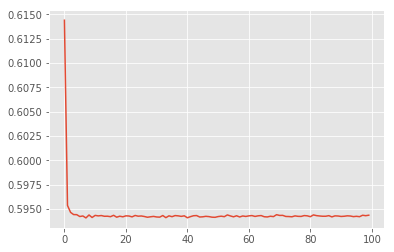

In [72]:
plt.plot(np.arange(num_epochs), L)


In [73]:
test_inputs = test_df[test_df.columns[1:-1]].values.astype(np.double)
test_inputs[:, 0:-1] = (test_inputs[:, 0:-1] - test_inputs[:, 0:-1].mean(axis = 0)) / test_inputs[:, 0:-1].std(axis = 0)
test_inputs = torch.tensor(test_inputs[:, 2:], dtype = torch.float, requires_grad = True)

test_targets = torch.tensor(test_df[test_df.columns[-1]].values.astype(np.double).reshape((test_df.shape[0], 1)), dtype = torch.float, requires_grad = False)


In [74]:
preds = model(test_inputs)


In [75]:
t = 0.5


In [76]:
TP = int(((preds >= t) & (test_targets == 1)).sum().item())
FP = int(((preds >= t) & (test_targets == 0)).sum().item())
FN = int(((preds < t) & (test_targets == 1)).sum().item())
TN = int(((preds < t) & (test_targets == 0)).sum().item())


In [77]:
prec = float(TP) / float(TP + FP)
rec = float(TP) / float(TP + FN)
acc = float(TP + TN) / float(test_targets.shape[0])
F1 = 2 * (acc * rec) / (acc + rec)


In [78]:
(prec, acc, rec, F1)


In [79]:
float((preds < t).sum().item()) / float(test_targets.shape[0])


In [80]:
dummy_preds = torch.tensor(np.random.binomial(1, float(targets.sum().item()) / float(targets.shape[0]), size = test_targets.shape), dtype = torch.float, requires_grad = False)


In [81]:
dummy_TP = int(((dummy_preds == 1) & (test_targets == 1)).sum().item())
dummy_FP = int(((dummy_preds == 1) & (test_targets == 0)).sum().item())
dummy_FN = int(((dummy_preds == 0) & (test_targets == 1)).sum().item())
dummy_TN = int(((dummy_preds == 0) & (test_targets == 0)).sum().item())


In [82]:
dummy_prec = float(dummy_TP) / float(dummy_TP + dummy_FP)
dummy_rec = float(dummy_TP) / float(dummy_TP + dummy_FN)
dummy_acc = float(dummy_TP + dummy_TN) / float(test_targets.shape[0])
dummy_F1 = 2 * (dummy_acc * dummy_rec) / (dummy_acc + dummy_rec)


In [83]:
(dummy_prec, dummy_acc, dummy_rec, dummy_F1)
